In [ ]:
import os
import ast
import boto3
import operator
import re
from langchain_chroma import Chroma
from langchain_aws import BedrockEmbeddings
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter


import pandas as pd
from operator import add
from typing import Literal
from typing import Annotated
from pydantic import BaseModel
from dotenv import load_dotenv
from langchain.schema import Document
from typing_extensions import TypedDict
from google.oauth2 import service_account
from langchain_community.vectorstores import FAISS
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langchain.document_loaders import DataFrameLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.vectorstores.base import VectorStoreRetriever


from pinecone import Pinecone
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec
from pinecone import Pinecone
import itertools
from typing import Annotated, TypedDict, List, Set


from langchain_aws import BedrockLLM, ChatBedrockConverse
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END

from tavily import TavilyClient

import boto3
import numpy as np
from langchain.embeddings import BedrockEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

import json
import groq


In [ ]:
os.environ['TAVILY_API_KEY'] = "YOUR-API_KEY"
os.environ['GROQ_API_KEY'] = "YOUR-API_KEY"
os.environ['AWS_ACCESS_KEY_ID'] = "YOUR-API_KEY"
os.environ['AWS_SECRET_ACCESS_KEY'] = "YOUR-API_KEY"
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2'

In [ ]:
bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-west-2'
)

bedrock_embeddings = BedrockEmbeddings(
    client=bedrock_client, region_name='us-west-2', model_id='amazon.titan-embed-text-v2:0'
)

bedrock_llama = ChatBedrockConverse(
    client=bedrock_client,
    region_name='us-west-2',
    model_id='meta.llama3-1-70b-instruct-v1:0'
)

def generate_embeddings(body):
    model_id = model_id='amazon.titan-embed-text-v2:0'
    accept = "application/json"
    content_type = "application/json"
    response = bedrock_client.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response.get('body').read())
    return response_body

groq_client = groq.Client(api_key=os.environ["GROQ_API_KEY"])
def groq_llama_3_3_70b_versatile(prompt: str) -> str:
    response = groq_client.chat.completions.create(
        model="llama-3.3-70b-versatile",  # Ensure correct model name
        messages=[{"role": "user", "content": prompt}],
    )

    return response.choices[0].message.content.strip()

In [ ]:
class MultiAgentState(TypedDict):
    question: str
    answer: str
    documents: Annotated[list[str], add]
    web_results: Annotated[list[str], add]
    web_ans: str
    SEC_ans:str
    CIK_value: str
    SEC_filing_tags: Annotated[list[str], add]
    followup_questions: Annotated[list[str], add]
    halt_execution: bool
    halt_SEC:bool

In [ ]:
def rewrite_q(state: MultiAgentState) -> MultiAgentState:
    SYS_PROMPT = """
    You are a great rewriter. When given a user’s question related to the finance or stock market field, rewrite the question in more detail, ensuring it remains a single, cohesive question while covering the essence of the original query. If the user's question is not related to finance or the stock market, return -1.
    Field of Topic: "Finance/Stock Market"

    Input:
    User Input: [User's question]
    Output:

    If the user's question is related to finance or the stock market, rewrite the question in greater detail, making sure it can be used for both further processing by another LLM or web search.
    If the user's question is unrelated to finance or the stock market, return -1.
    Examples:

    User Input: "How can I invest in the stock market?"
    Output: "What are the steps to start investing in the stock market for beginners?"

    User Input: "What is the best time to buy stocks?"
    Output: "When is the optimal time to buy stocks for maximum returns?"

    User Input: "How do stock prices go up and down?"
    Output: "What factors cause fluctuations in stock prices in the stock market?"

    User Input: "What is a good strategy for stock trading?"
    Output: "What are the most effective stock trading strategies for long-term growth?"

    User Input: "What is a dividend in stock market?"
    Output: "What does a dividend mean in the context of stock market investing?"

    User Input: "What is the weather like in Paris?"
    Output: -1

    Be on point while generating a question!
    Return only re-written question, or -1. (Donot return anything else!)
"""



    question = state["question"]
    prompt = SYS_PROMPT.replace("[User's question]", question)
    llm = bedrock_llama
    rewritten_question = llm.invoke(prompt)


    rewritten_question_content = str(rewritten_question.content.strip())
    if rewritten_question_content != str(-1):
        return {"question": rewritten_question_content, "halt_execution": False}
    else:
        return {"answer": "Please ask a valid question", "halt_execution": True}

In [ ]:
def get_CIK(state: MultiAgentState) -> MultiAgentState:
    SYS_PROMPT = """
Find the 10-digit CIK for the company mentioned in the given question. Retain leading zeros and return only the CIK value. If the CIK is not found, return -1.

Input:
User Input: [User's question]

Output:
Return only the CIK value or -1. Do not include any additional text.
"""
    question = state["question"]
    prompt = SYS_PROMPT.replace("[User's question]", question)
    llm = bedrock_llama
    rewritten_question = llm.invoke(prompt)

    rewritten_question_content = str(rewritten_question.content.strip())
    if rewritten_question_content != str(-1):
        return {"CIK_value": rewritten_question_content,"halt_SEC":False}
    else:
        return {"halt_SEC": True}

In [ ]:
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

def web_search(state: MultiAgentState) -> MultiAgentState:
    query = state["question"]
    results = tavily_client.search(query=query, search_depth="basic")
    top_results = [r["content"] for r in results["results"][:10]]
    return {"web_results": top_results}

In [ ]:
def web_gen_ans(state: MultiAgentState) -> MultiAgentState:
    question = state["question"]
    body = json.dumps({
        "inputText": question,
        "embeddingTypes": ["binary"]
    })
    question_embedding = np.array(generate_embeddings(body)["embeddingsByType"]["binary"])


    web_results = state["web_results"]
    combined_web_results =  " ".join(web_results)

    docs = [Document(page_content=combined_web_results)]
    splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
    chunked_docs = splitter.split_documents(docs)


    embeddings = []
    for doc in chunked_docs:
        body = json.dumps({
        "inputText": doc.page_content,
        "embeddingTypes": ["binary"]
    })
        embeddings.append(generate_embeddings(body)["embeddingsByType"]["binary"])

    embeddings = np.array(embeddings)
    cosine_similarities = cosine_similarity([question_embedding], embeddings)

    top_3_indices = np.argsort(cosine_similarities[0])[::-1][:3]
    top_3_docs = [chunked_docs[i].page_content for i in top_3_indices]
    context = "\n".join([doc for doc in top_3_docs])

    SYS_PROMPT = """
You are an advanced language model trained to generate answers based strictly on the provided context.
If the context contains the answer to the question, respond accordingly.

Context:
{context}

Question: {question}
Answer:

Display only new answer generated, do not give additional information.
    """



    prompt = SYS_PROMPT.replace("{context}", context).replace("{question}", question)
    final_ans = groq_llama_3_3_70b_versatile(prompt)

    if final_ans != str(-1):
        return {"web_ans":final_ans}
    else:
        return {"web_ans":"-1"}


In [ ]:
def get_SEC_filings_tags(state: MultiAgentState) -> MultiAgentState:
    question = state["question"]

    SYS_PROMPT = SYS_PROMPT = """
    You are an intelligent assistant that determines whether SEC (Securities and Exchange Commission) filings data is sufficient to answer a given question about a company’s financials, operations, or performance. Based on the user's question, decide if the SEC filings, reports, or disclosures can provide enough information to answer it. Below is the list of available SEC filing types and their descriptions. If the question is related to any of these forms and sufficient information can be obtained from them, respond with the keys of the most relevant forms in a list format.

    Here is the available SEC data:

    ['PX14A6G', '144', '10-Q', '8-K', '3', 'DEFA14A', 'DEF 14A', 'S-3ASR', '10-K', '5', 'SD', 'SC 13G/A', '25-NSE', '424B2', 'FWP', '4/A', 'S-8', 'S-8 POS', 'PX14A6N', 'CERT', '8-A12B', '3/A', '25', 'SC 13G', '8-K/A']

    Input:

    User Input: [User's question]

    Output:

    If the question can be answered sufficiently using SEC data, return all the key(s) of the most relevant form(s) in a list format.
    (Donot return anything else!)
"""

    prompt = SYS_PROMPT.replace("[User's question]", question)
    llm = bedrock_llama
    rewritten_question = llm.invoke(prompt)
    rewritten_question_content = ast.literal_eval(str(rewritten_question.content.strip()))

    return {"SEC_filing_tags":rewritten_question_content}







In [ ]:
def get_SEC_filings_data(state: MultiAgentState) -> MultiAgentState:
    question = state["question"]
    tags = state["SEC_filing_tags"]
    CIK_value = state["CIK_value"]

    tempdocs = []
    for i in range(len(tags)):
        combined_string = re.sub(r'[^a-zA-Z0-9_-]', '_', f"{CIK_value}_{i}")
        combined_string = re.sub(r'_{2,}', '_', combined_string)
        chroma_db = Chroma(persist_directory="./SEC_DATA", collection_name=combined_string, embedding_function=bedrock_embeddings)
        similarity_threshold_retriever = chroma_db.as_retriever( search_type="similarity_score_threshold", search_kwargs={"k": 2,"score_threshold": 0.2} )
        top_docs = similarity_threshold_retriever.invoke(question)
        if top_docs:
            for doc in top_docs:
                tempdocs.append(doc.page_content)
    if tempdocs:
        return {"documents":tempdocs}
    else:
        return {"halt_SEC":True}

In [ ]:
def SEC_gen_ans(state: MultiAgentState) -> MultiAgentState:
    question = state["question"]
    docks  = state["documents"]

    context = "\n".join([doc for doc in docks])

    SYS_PROMPT = """
You are an advanced language model trained to generate answers based strictly on the provided context.
If the context contains the answer to the question, respond accordingly and return -1.

Context:
{context}

Question: {question}
Answer:

Display only new answer generated, do not give additional information.
    """



    prompt = SYS_PROMPT.replace("{context}", context).replace("{question}", question)
    llm = groq_llama_3_3_70b_versatile
    final_ans = groq_llama_3_3_70b_versatile(prompt)

    if final_ans != str(-1):
        print()
        return {"SEC_ans":final_ans}
    else:
        return {"SEC_ans":str("-1")}


In [ ]:
def final_gen_ans(state: MultiAgentState) -> MultiAgentState:
    question = state["question"]
    SEC_ans = state.get("SEC_ans", "")
    web_ans  = state["web_ans"]

    if  SEC_ans:
        context = "Answer generated from SEC data is: " + SEC_ans + "\n" + "Web generated answer is: "+ web_ans
    else:
        context = "Web generated answer is: "+ web_ans



    SYS_PROMPT = """
You are an advanced language model trained to generate answers based strictly on the provided context.


Context:
{context}

Question: {question}
Answer:

Display only new answer generated, do not give additional information.
    """



    prompt = SYS_PROMPT.replace("{context}", context).replace("{question}", question)
    llm = groq_llama_3_3_70b_versatile
    final_ans = groq_llama_3_3_70b_versatile(prompt)

    if final_ans != str(-1):
        return {"answer":final_ans}
    else:
        return {"answer":"No answer found! Please try with a different question."}


In [ ]:
def suggested_Questions(state: MultiAgentState) -> MultiAgentState:
    question = state["question"]
    answer = state.get("answer", "")


    SYS_PROMPT = """
You are a knowledgeable assistant tasked with generating relevant questions based on the given question and its answer with field. Based on the context provided, suggest three new questions that could logically follow the initial question. The new questions should explore related aspects or provide deeper insights into the topic.

question: {question}
answer: {answer}
field: Finance/ Stock market


Suggested Questions:
all Suggested Questions should be in new line. Only give questions, nothing else! Only make 3 new Questions!
    """



    prompt = SYS_PROMPT.replace("{question}", question).replace("{answer}", answer)
    llm = groq_llama_3_3_70b_versatile
    final_ans = groq_llama_3_3_70b_versatile(prompt)
    final_ans = final_ans.split("\n")

    return {"followup_questions":final_ans}


In [ ]:
workflow = StateGraph(MultiAgentState)
workflow.add_node("Rewrite_Question", rewrite_q)

workflow.add_node("Get_CIK_Value", get_CIK)
workflow.add_node("Gen_SEC_filing_Tags", get_SEC_filings_tags)
workflow.add_node("Gen_SEC_filing_Data", get_SEC_filings_data)
workflow.add_node("Gen_SEC_ANS", SEC_gen_ans)



workflow.add_node("Get_web_Data", web_search)
workflow.add_node("Gen_Web_ANS", web_gen_ans)
workflow.add_node("Final_ANS", final_gen_ans)
workflow.add_node("Follow_up_Questions", suggested_Questions)


workflow.set_entry_point("Rewrite_Question")
workflow.add_edge("Rewrite_Question", "Get_CIK_Value")
workflow.add_edge("Get_CIK_Value", "Gen_SEC_filing_Tags")
workflow.add_edge("Gen_SEC_filing_Tags", "Gen_SEC_filing_Data")
workflow.add_edge("Rewrite_Question", "Get_web_Data")
workflow.add_edge("Gen_SEC_filing_Data", "Gen_SEC_ANS")
workflow.add_edge("Gen_SEC_ANS", "Final_ANS")
workflow.add_edge("Get_web_Data", "Gen_Web_ANS")
workflow.add_edge("Gen_Web_ANS", "Final_ANS")

workflow.add_edge("Final_ANS", "Follow_up_Questions")
workflow.add_edge("Follow_up_Questions", END)

graph = workflow.compile()

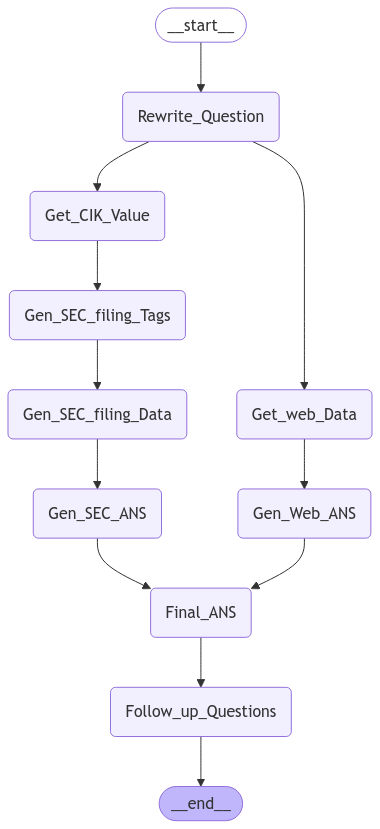

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
output = graph.invoke({
    "question": "Apple filing say about Earnings Per Share?",
})

No relevant docs were retrieved using the relevance score threshold 0.2
No relevant docs were retrieved using the relevance score threshold 0.2


In [ ]:
output

{'question': "What information does Apple's latest earnings filing reveal about its Earnings Per Share (EPS) performance, and how does it compare to previous quarters and analyst expectations?",
 'answer': "Apple's latest earnings filing reveals that the company reported an EPS of $2.40, which beat analysts' consensus estimates of $2.36 by $0.04. This EPS performance is the same as the previous quarter, where Apple also reported $2.40 earnings per share, beating the analysts' consensus estimate of $2.36 by $0.04. The current EPS represents a 10% year-over-year increase.",
 'documents': [],
 'web_results': ["Apple (AAPL) Earnings Date and Reports 2025 Trending MarketBeat Stocks Top-Rated Stocks Top-Rated Dividend Stocks Earnings Stocks by Interest Stocks Under $0.50 Stocks Under $1 Stocks Under $2 Stocks Under $5 Top-Rated Stocks Top-Rated Dividend Stocks Apple (AAPL) Earnings Date, Estimates & Call Transcripts Earnings Earnings Apple issued Q1 2025 earnings on January 30, 2025, reporti

In [ ]:
output["answer"]

"Apple's latest earnings filing reveals that the company reported an EPS of $2.40, which beat analysts' consensus estimates of $2.36 by $0.04. This EPS performance is the same as the previous quarter, where Apple also reported $2.40 earnings per share, beating the analysts' consensus estimate of $2.36 by $0.04. The current EPS represents a 10% year-over-year increase."

In [ ]:
output["followup_questions"]

["What factors contributed to Apple's EPS growth, and how did revenue from different product segments impact the company's overall financial performance?",
 "How do Apple's EPS results compare to those of its main competitors in the technology industry, and what does this say about the company's market position?",
 "What are the implications of Apple's EPS beat for investor sentiment and the company's stock price, and how might this impact future earnings expectations and valuations?",
 "What factors contributed to the 10% year-over-year increase in Apple's EPS, and are they expected to continue driving growth in future quarters?",
 "How do Apple's EPS results compare to those of its main competitors in the tech industry, such as Microsoft and Alphabet?",
 "What implications do Apple's EPS performance and revenue growth have on the company's stock price and overall market valuation in the short and long term?"]